In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
import mlflow

In [2]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

In [3]:
def get_experiment_df(experiment_name):
    client = MlflowClient()
    exp_id = client.get_experiment_by_name(experiment_name)

    if exp_id is None:
        return None
    runs_df = mlflow.search_runs(experiment_ids=[exp_id.experiment_id])

    runs_df.columns = [re.sub("params.", "", col) for col in runs_df.columns]
    runs_df.columns = [re.sub("metrics.", "", col) for col in runs_df.columns]
    
    
    return runs_df

## RESULTS FOR 70% OF POOL DATA

In [4]:
mlflow.search_experiments()

[<Experiment: artifact_location='file:///scratch/potter.mi/LogisticALBenchmark/mlruns/474241495440491713', creation_time=1725587750819, experiment_id='474241495440491713', last_update_time=1725587750819, lifecycle_stage='active', name='AL_fixed', tags={}>,
 <Experiment: artifact_location='file:///scratch/potter.mi/LogisticALBenchmark/mlruns/688328213376658147', creation_time=1725533750786, experiment_id='688328213376658147', last_update_time=1725533750786, lifecycle_stage='active', name='AL_reproducibility_small', tags={}>,
 <Experiment: artifact_location='file:///scratch/potter.mi/LogisticALBenchmark/mlruns/767125422517401034', creation_time=1725509109867, experiment_id='767125422517401034', last_update_time=1725509109867, lifecycle_stage='active', name='AL_reproducibility', tags={}>,
 <Experiment: artifact_location='file:///scratch/potter.mi/LogisticALBenchmark/mlruns/0', creation_time=1725509109723, experiment_id='0', last_update_time=1725509109723, lifecycle_stage='active', name='D

In [5]:
experiment_name = "AL_fixed"

In [6]:
mlflow_df = get_experiment_df(experiment_name)

In [7]:
coi = ['alc_test','accuracy_baseline','accuracy_test','dataset','query_method_name']
mlflow_df = mlflow_df[coi]

In [8]:
# Step 1: Create a dictionary with random 'alc_test' values for each dataset
random_alc_values = mlflow_df[mlflow_df['query_method_name'] == 'random'].set_index('dataset')['alc_test'].to_dict()

# Step 2: Divide each 'alc_test' by the corresponding 'random' value for each dataset
def divide_by_random(row):
    dataset = row['dataset']
    if dataset in random_alc_values:
        random_value = random_alc_values[dataset]
        if pd.notna(random_value) and pd.notna(row['alc_test']):  # Avoid division by NaN
            return row['alc_test'] / random_value
    return None  # For NaN or missing datasets

# Apply the function to create a new column with the divided values
mlflow_df['alc_ratio'] = mlflow_df.apply(divide_by_random, axis=1)

In [9]:
mlflow_df.isna().values.any(axis=-1).sum()

3

In [10]:
mlflow_df[mlflow_df[['dataset','query_method_name','alc_test']].duplicated()]

,alc_test,accuracy_baseline,accuracy_test,dataset,query_method_name,alc_ratio
56,NaN,NaN,NaN,None,None,NaN
57,NaN,NaN,NaN,None,None,NaN


In [11]:
alc_df = mlflow_df.pivot_table(index='dataset', columns='query_method_name', values='alc_test', aggfunc='mean')
alc_df = alc_df.reindex(columns=['random','entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'])
alc_df.style.apply(highlight_max, axis=1)

query_method_name,random,entropy,error_reduction,max_error_reduction,fivr,max_model_change
dataset,,,,,,
acute,0.970301,0.991622,0.971166,0.958289,0.991888,0.991711
breast_cancer,0.948665,0.959362,0.956720,0.963689,0.960815,0.959939
diabetes,0.740397,0.732617,0.738006,0.727274,0.748418,0.727148
haberman,0.727129,0.709937,0.716059,0.710071,0.729745,0.703946
heart_disease,0.767619,0.804452,0.798174,0.787924,0.799390,0.803924
ionosphere,0.835470,0.850656,0.854750,0.847834,0.860918,0.787256
parkinsons,0.772952,0.828538,0.805028,0.821429,0.829387,0.836896
pima,0.749356,0.748952,0.749217,0.725258,0.756009,0.734939
planning,0.583812,0.593605,0.598487,0.594537,0.586077,0.604225


/tmp/ipykernel_15140/1207533061.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)


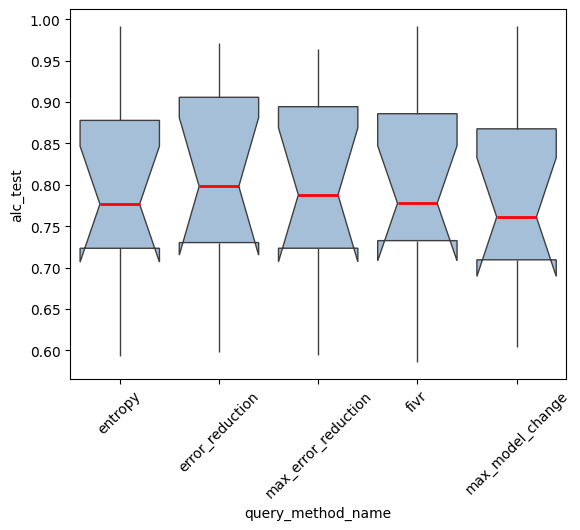

In [12]:
boxplot = sns.boxplot(
    data=mlflow_df, x="query_method_name", y="alc_test",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .5, .7, .5)},
    medianprops={"color": "r", "linewidth": 2},
        order=['entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'],
)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)
plt.show()

In [13]:
means = mlflow_df[mlflow_df.query_method_name!="random"][['query_method_name','alc_ratio']].groupby('query_method_name').mean().reindex(['entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'])
means

,alc_ratio
query_method_name,
entropy,1.015599
error_reduction,1.013705
max_error_reduction,1.005051
fivr,1.015283
max_model_change,1.001412


/tmp/ipykernel_15140/1598602178.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)


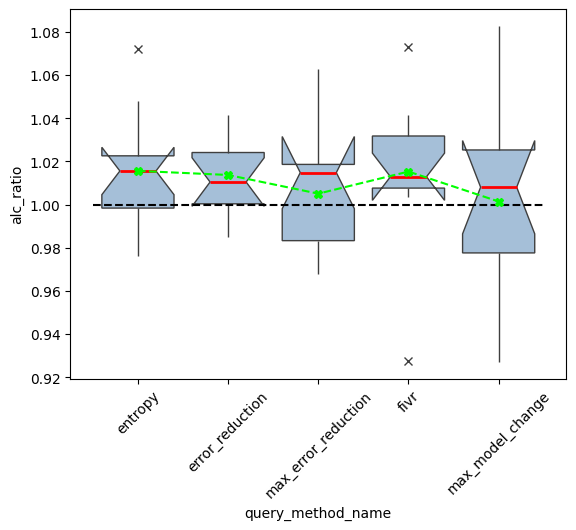

In [14]:
boxplot = sns.boxplot(
    data=mlflow_df[mlflow_df.query_method_name!="random"], x="query_method_name", y="alc_ratio",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .5, .7, .5)},
    medianprops={"color": "r", "linewidth": 2},
    order=['entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'],
)


xticks = boxplot.get_xticks()

boxplot.plot([xticks[0]-0.5,xticks[-1]+0.5],[1,1],'k--')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)
boxplot.plot(xticks,means.values,'X--',color='lime',zorder=5)
plt.show()

# ACC CURVES

In [26]:
import os
import os.path as osp
import matplotlib as mpl

dataset = "ionosphere"
folder = "fixed"
lam_config = "lam_0.01"


result_path = osp.join("results",folder,dataset)

results = {}

for fold in os.listdir(result_path):
    score_path = osp.join(result_path,fold,lam_config)
    scores = np.load(osp.join(score_path,"score_matrix_test.npy"))
    
    results[fold] = scores

In [27]:
accuracy_baseline = mlflow_df[mlflow_df.dataset==dataset].iloc[0].accuracy_baseline

cmap = mpl.colormaps['jet']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(results)))

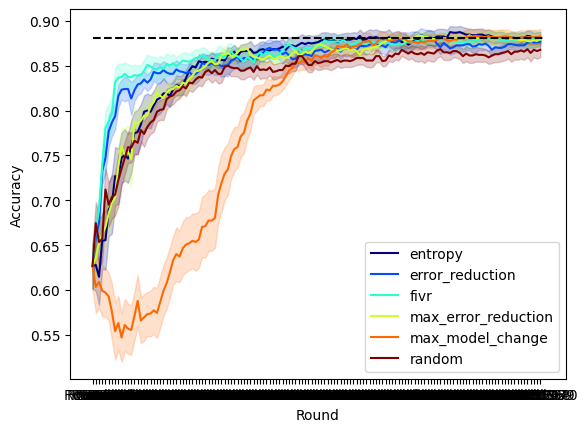

In [28]:
plt.figure()
for i,(fold,val) in enumerate(results.items()):
    # Convert the matrix to a DataFrame
    df = pd.DataFrame(val, columns=[f'Round {i+1}' for i in range(val.shape[-1])])
    
        # Melt the DataFrame to long format for seaborn
    df_long = df.melt(var_name='Round', value_name='Accuracy')

    sns.lineplot(data=df_long, x='Round', y='Accuracy', errorbar='se',label=fold,color=colors[i])  # 'sd' gives the standard deviation as confidence interval

plt.plot([0,val.shape[-1]],[accuracy_baseline,accuracy_baseline],'k--')
plt.legend()